시각자료 plot 코드만 참고하셔서 학습 진행 후 결과 자료 톡방에 공유해주시면 될 것 같습니다. 쓸데없는 주석처리 해둔 코드들은 지웠고, 추가적으로 코멘트를 달아야 할 정도의 코드는 없어보여서 작성 안했는데, 궁금하신 부분 있으시면 바로바로 톡방에 말씀 남겨주시면 확인 후 답 드리겠습니다 !

In [16]:
###### USER SETTING ########
train_samples_ratio = 0.8 # train and test split ratio setting
ParameterNum = 301 # 301 : Vth / 302 : mobility / 303 : ss / 304 : on/off ratio # 추출하고자 하는 Parameter setting
n_epochs = 30000
batch_size = 128
learning_rate = 0.001
patience = 300
############################

In [7]:
import warnings
warnings.filterwarnings(action = 'ignore')
import os
import klib
import natsort
from scipy.stats import skew
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

load dataset

In [8]:
dataset_id = np.load(r'D:\TFT(IGZO_SAL)_DL\DL\input dataset\Filtered_Dataset_(20240520 종합).npz')['dataset']
dataset_parameter = np.load(r'D:\TFT(IGZO_SAL)_DL\Ground Truth\Ground Truth_(20240520 종합).npz')['dataset']

# Drain Current dataset + Parameter(Ground Truth) dataset 병합
## col0 to 300 : drain current / col301 : Vth / col302 : mobility / col303 : S-slope / col304 : onoff ratio
dataset_id_parameter = np.concatenate((dataset_id, dataset_parameter), axis = 1)

train test split

In [17]:
# train and test data split_02 - Applied RandomShuffle Split ---- 작성하신 코드 그대로 참고해서 작성한 부분입니다.

df_id_parameter = pd.DataFrame(data = dataset_id_parameter)
TrainDataFrame = df_id_parameter.sample(frac = train_samples_ratio, random_state = 24)
TestDataFrame = df_id_parameter.drop(TrainDataFrame.index)
TrainDataset = np.array(TrainDataFrame)
TestDataset = np.array(TestDataFrame)

train_input = TrainDataset[:, :301]
train_target = TrainDataset[:, ParameterNum]
train_target = np.expand_dims(train_target, axis = 1)

test_input = TestDataset[:, :301]
test_target = TestDataset[:, ParameterNum]
test_target = np.expand_dims(test_target, axis = 1)

############################################################################################################

print(f'TrainDataset : {TrainDataset.shape} TestDataset : {TestDataset.shape}')
print(f'train_input : {train_input.shape} / train_target : {train_target.shape} \
test_input : {test_input.shape} / test_target : {test_target.shape}')

TrainDataset : (485, 305) TestDataset : (121, 305)
train_input : (485, 301) / train_target : (485, 1) test_input : (121, 301) / test_target : (121, 1)


In [19]:
# Regressor 성능 평가 지표
def RMSE(test_target, test_pred) :
    return np.sqrt(mean_squared_error(test_target, test_pred))

def MAPE(test_target, test_pred) :
	return np.mean(np.abs((test_target - test_pred) / test_target)) * 100


Normalization

In [20]:
# Normalization - 적용해볼 만한 기법 3가지

# log10 transform

train_input = np.log10(train_input)
test_input = np.log10(test_input)

# standardization

mean = train_input.mean(axis=0)
std = train_input.std(axis=0)
train_input = (train_input - mean) / std
test_input = (test_input - mean) / std

############# On/Off Ratio 학습 시 ! #############
# OnOff Ratio ground truth Normalization
# train_target = np.log10(train_target)
# test_target = np.log10(test_target)
############# On/Off Ratio 학습 시 ! #############


model build

In [13]:
# DNN Model setting

model = tf.keras.Sequential()
model.add(Dense(100, activation='relu', input_shape=(train_input.shape[1],)))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer = optimizer, loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               30200     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45,401
Trainable params: 45,401
Non-trainable params: 0
_________________________________________________________________


In [14]:
# EarlyStopping Setting

callbacks = [
    EarlyStopping(monitor = 'val_loss',
                  patience = patience,
                 )
]

In [423]:
# # Model Train

history = model.fit(train_input, train_target,
                    epochs = n_epochs, 
                    batch_size = batch_size,
                    validation_split=0.25,
                    callbacks = callbacks,
                   )

Epoch 1/30000
1/3 [=========>....................] - ETA: 0s - loss: 13501372768926564352.0000 - mae: 1199677696.0000
Epoch 1: val_loss improved from inf to 1880093964996968448.00000, saving model to D:/TFT(IGZO_SAL)_DL/DL/DNN/TrainResults/checkpoints/OnOffratio_lr0.001_epoch30000_Adam_zscore_patience300_batch128_240525\epoch01-val_Loss1880093964996968448.000-mae1038418176.000.h5
3/3 [==============================] - 1s 162ms/step - loss: 7819563419266187264.0000 - mae: 1038418176.0000 - val_loss: 1880093964996968448.0000 - val_mae: 928032256.0000
Epoch 2/30000
1/3 [=========>....................] - ETA: 0s - loss: 9833831887712288768.0000 - mae: 1173413376.0000
Epoch 2: val_loss did not improve from 1880093964996968448.00000
3/3 [==============================] - 0s 48ms/step - loss: 7819562319754559488.0000 - mae: 1038418176.0000 - val_loss: 1880093964996968448.0000 - val_mae: 928032256.0000
Epoch 3/30000
1/3 [=========>....................] - ETA: 0s - loss: 7867433406760484864.000

Model Train 이후 코드는 제 것이 아닌 작성하신 코드 사용하시면 될 것 같습니다.
시각자료 plot 코드만 참고하셔서 학습 진행 후 결과 데이터 톡방에 올려주시면 될 것 같습니다.

In [426]:
# Model Evaluate

scores = model.evaluate(test_input, test_target)
print(f'Test_Loss : ', scores[0])
print(f'Test_MAE : ', scores[1])

4/4 [==============================] - 0s 6ms/step - loss: 527434971929903104.0000 - mae: 528379872.0000
Test_Loss :  5.274349719299031e+17
Test_MAE :  528379872.0


In [427]:
# Model Test setting

prediction = model.predict(test_input)
test_result = np.concatenate((prediction, test_target), axis = 1)
# test_result = test_result[test_result[:, 1].argsort()]

# 성능 평가 지표 값 확인

RMSE_value = RMSE(test_target, prediction[:, 0])
MAPE_value = MAPE(test_target, prediction[:, 0])
print(f'RMSE : {RMSE_value}, MAPE : {MAPE_value}')


4/4 [==============================] - 0s 0s/step
RMSE : 726247172.4572866, MAPE : 162.25042283994182


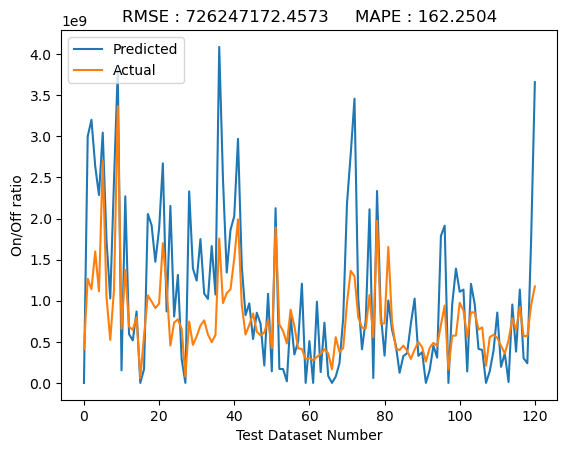

In [428]:
# Test Results Visualization setting

ParameterLabel = ['Threshold Voltage [V]', 'Saturation Mobility [cm^2/V-sec]', 'Subthreshold Slope [V/dec]', 'On/Off ratio']

plt.figure(5)
plt.title('RMSE : ' + str(np.round(RMSE_value, 4)) + '     ' +'MAPE : ' + str(np.round(MAPE_value, 4)))
plt.plot(list(range(len(prediction))), test_result[:, 0], label='Predicted')
plt.plot(list(range(len(prediction))), test_result[:, 1], label='Actual')
plt.xlabel('Test Dataset Number')
plt.ylabel(ParameterLabel[ParameterNum-301])
plt.legend(loc = 'upper left')


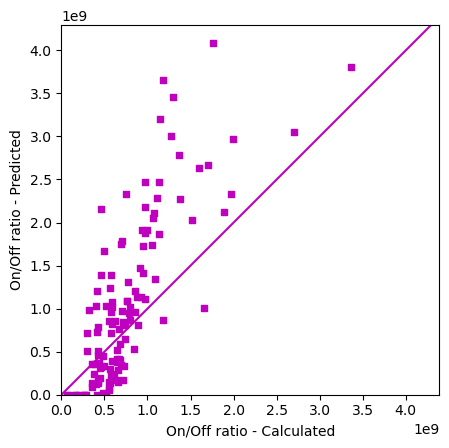

In [429]:
plot_color = ['r','g','b','m']
plt.figure()
plt.scatter(x = test_result[:, 1], 
            y = test_result[:, 0],
            marker = 's',
            color = plot_color[ParameterNum-301],
            s = 15)

plt.xlabel(ParameterLabel[ParameterNum-301] + ' - Calculated')
plt.ylabel(ParameterLabel[ParameterNum-301] +' - Predicted')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
if ParameterNum == 304 :
    plt.plot([-1e-10, 1e+10], [-1e-10, 1e+10], color = plot_color[ParameterNum-301])
else :
    plt.plot([-100, 100], [-100, 100], color = plot_color[ParameterNum-301])
